In [2]:
import matplotlib.pyplot as plt
import glob
import torch
import numpy as np
import networkx as nx
import os
import matplotlib as mpl
plt.rcParams.update({'font.size': 16})

In [3]:
# Load the data
data_dir = "../results_scaling/"

# Delaunay
sub_dir = os.path.join(data_dir, "2021-11-20_10-03_scaling_dinno_const_fied") 
# Star
#sub_dir = os.path.join(data_dir, "2021-11-20_07-04_scaling_dinno_const_fied") 

graph_pickles = glob.glob1(sub_dir, "*.gpickle")
num_trials = len(graph_pickles)

results_all = []
graphs_all = []
for k in range(num_trials):
    graph_path = os.path.join(sub_dir, str(k) + ".gpickle")
    results_path = os.path.join(sub_dir, str(k) + "_results.pt")
    graph = nx.read_gpickle(graph_path)
    results = torch.load(results_path, map_location=torch.device("cpu"))
    graphs_all.append(graph)
    results_all.append(results)

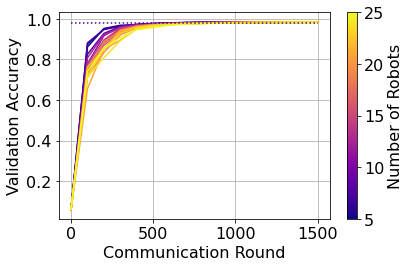

In [22]:
# Plot the accuracy per iteration
fig, ax = plt.subplots(tight_layout=True)
color_val = np.linspace(0, 1, num_trials)
for k in range(num_trials):
    if k == 5:
        continue
    acc = results_all[k]["top1_accuracy"]
    acc = torch.stack(acc)
    mean = torch.mean(acc, dim=1)
    t = torch.arange(acc.shape[0]) * 100
    ax.plot(t, mean, c=mpl.cm.plasma(color_val[k]))

cmap = mpl.cm.plasma
units = mpl.colors.Normalize(vmin=5, vmax=25)
fig.colorbar(mpl.cm.ScalarMappable(norm=units, cmap=cmap),
    ax=ax, label="Number of Robots", ticks=[5, 10, 15, 20, 25])

ax.plot(t, 0.98 * np.ones_like(mean), c="indigo", linestyle=":")

ax.set_ylabel("Validation Accuracy")
ax.set_xlabel("Communication Round")
ax.grid()


Text(0.5, 0, 'Number of Robots')

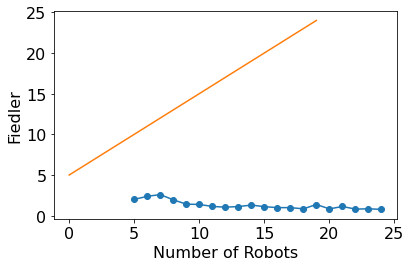

In [23]:
fieds = [nx.linalg.algebraic_connectivity(graphs_all[k]) for k in range(num_trials)]
Ns = [len(graphs_all[k].nodes) for k in range(num_trials)]

fig, ax = plt.subplots(tight_layout=True)
ax.plot(Ns, fieds, marker="o")
ax.set_ylabel("Fiedler")
ax.set_xlabel("Number of Robots")